In [1]:
from mm_ab import *

In [45]:
@dataclass
class Bandit():
    '''
    Наш базовый бандюга.\n
    q : Настоящая вероятность успеха бандита\n
    alpha : Кол-во успешних событий\n
    beta : Кол-во проваленных событий\n
    '''
    q : float
    alpha : int = 1
    beta : int = 1

    def sample(self):
        '''
        Получаем точечную оценку нашего бандита\n
        Генерируем случайное случайный рейт успеха из распределения бандита для сравнения с другими
        '''
        return sps.beta(self.alpha,self.beta).rvs()
    
    def update(self,R):
        '''
        Обновляем бандитские данные, записываем наши успехи и не успехи
        '''
        self.alpha += R
        self.beta += (1-R)
    
    def check_arm(self):
        '''
        Крутим ручку бандита из его реального распределения
        '''
        return np.random.binomial(1,self.q)

In [226]:
get_ab_size(mde = 0.01,std=.30,n_groups=2)

14127.983521828359

  0%|          | 0/30000 [00:00<?, ?it/s]

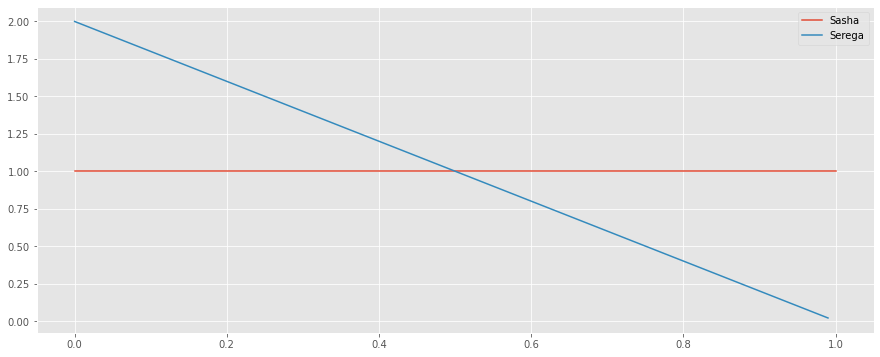

 17%|█▋        | 4991/30000 [00:11<00:54, 455.29it/s]

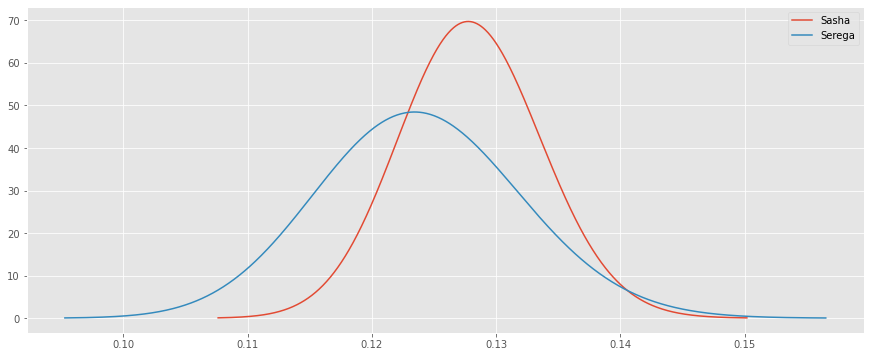

 33%|███▎      | 9962/30000 [00:22<00:44, 450.30it/s]

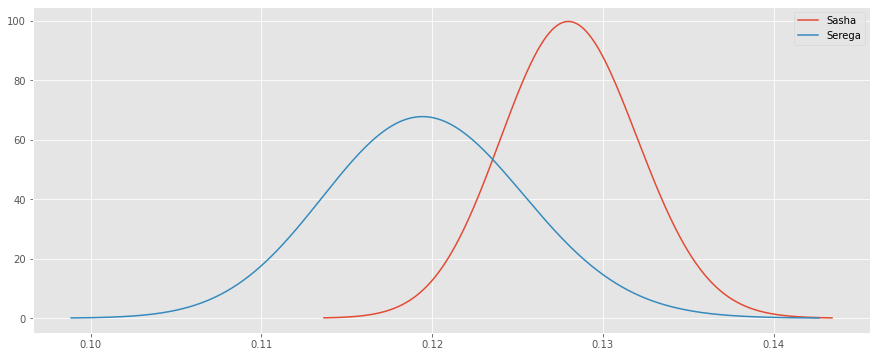

 50%|████▉     | 14977/30000 [00:33<00:32, 463.49it/s]

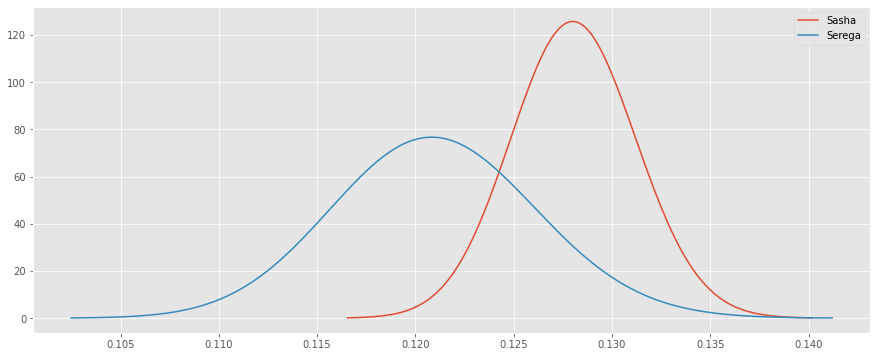

 67%|██████▋   | 19996/30000 [00:44<00:21, 463.24it/s]

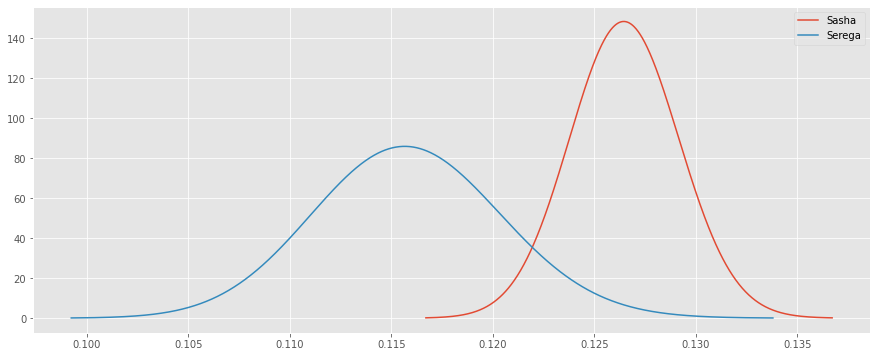

 83%|████████▎ | 24956/30000 [00:55<00:10, 459.46it/s]

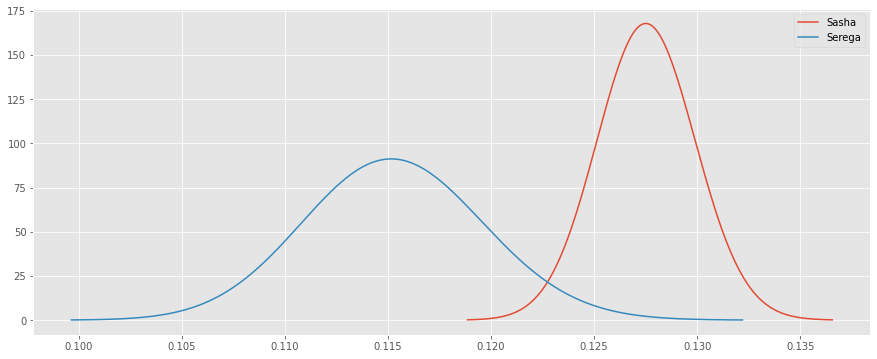

100%|██████████| 30000/30000 [01:06<00:00, 451.99it/s]


In [192]:
# Создаем парочку бандитов
arms = {'Sasha' : Bandit(.125),
        # 'Kolyan' : Bandit(.11),
        'Serega' : Bandit(.115)
        }
        
# Табличка отданных голосов
result = {'Sasha':0,'Kolyan':0,'Serega':0}
ab_df = pd.DataFrame()
exploring=True
for i in tqdm(range(30000)):
    # Бандюги
    # --------------------------------------------------
    # Крутим ручки
    arms_check = {name:bandit.sample() for name,bandit in arms.items()} 
    # Выбираем победителя
    winner = max(arms_check,key=arms_check.get)
    # Убираем его из пула
    arms_check.pop(winner)
    if exploring:
    # Выбираем нашего следующего кандидата рандомно для исследовать
        explore = np.random.choice(list(arms_check.keys()))
        winner = np.random.choice([winner,explore],p=[0.9,0.1])
    # Проверяем нашего счастливчика
    spin_result = arms[winner].check_arm()
    # Обновляем наши реальные данные
    arms[winner].update(spin_result) 
    # Сохраняем наши результаты
    result[winner] += spin_result
    # АБ
    # --------------------------------------------------
    ab = pd.Series({name:bandit.check_arm() for name,bandit in arms.items()}).to_frame().T
    ab_df = ab_df.append(ab)

    if i % 5000 == 0:
        for name,obj in arms.items():
            arm_distribution = stats.beta(obj.alpha,obj.beta)
            x = np.linspace(*arm_distribution.ppf([0.0001,.9999]),1000)
            y = arm_distribution.pdf(x)
            plt.plot(x,y)
            # plt.hist(stats.beta(obj.alpha,obj.beta).rvs(100000),bins=1000,alpha=0.5);
            plt.legend(arms.keys())
        plt.show()


In [200]:
pval_df = pd.DataFrame()
for i in tqdm(range(15000)):
    pvals = {
            'ttest':sps.ttest_ind(ab_df.iloc[:i]['Sasha'],ab_df.iloc[:i]['Serega']).pvalue,
            }
    pval_df = pval_df.append(pd.Series(pvals).rename(i)).fillna(1)

100%|██████████| 20000/20000 [00:37<00:00, 532.68it/s]


<AxesSubplot:>

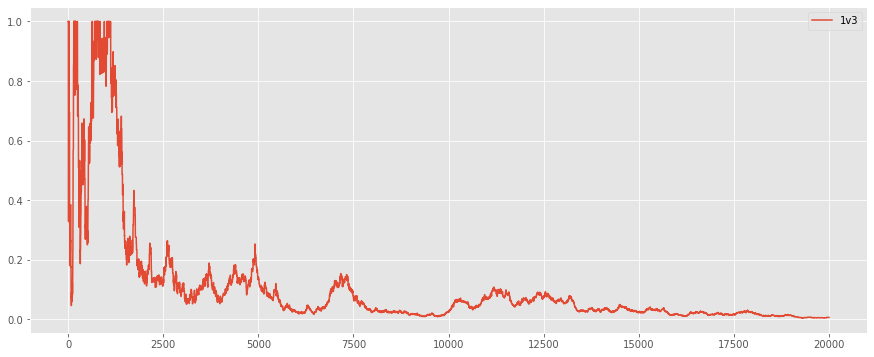

In [223]:
pval_df.plot()

In [222]:
np.sum(list(result.values()))

3705

In [221]:
ab_df.iloc[:15000].sum().sum()

3623